<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/Zemlyakov_Serj/Int_1_%D0%9F%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3_2_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Работа с массивами данных
import numpy as np 

# Работа с табличными данными
import pandas as pd

import string

import tensorflow as tf

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

import random

#Для работы с файлами 
import os 

from google.colab import files

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split

!pip install tensorflow-addons

import tensorflow_addons as tfa

from tensorflow_addons.metrics import F1Score

!pip install PyDrive --upgrade

# Импорт необходимых библиотек
import os
from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

%matplotlib inline



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 35.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mount Google Drive
import os
from google.colab import drive

drive.mount('/content/drive')
!pwd
!ls



In [2]:
# Загрузка базы данных заказчика, предварительно сохарненной в формате *.csv
df = pd.read_csv('/content/drive/MyDrive/internsheep1/profpat_1.csv')


<ipython-input-2-7b983cea7a77>:2: DtypeWarning: Columns (24,25,26,43,44,45,46,47,48,54,55,56,57,58,59,60,61,62,63,64,65,77,78,79,81,84,85,86,87,88,89,90,91,92,108,109,112,113,120,121,122,123,124,125,126,127,162,163,164,168,169,170,171,172,173,174,195,196,201,202,203,204,205,206,207,208,221,222,223,228,229,230,252,253,258,259,260,261,262,263,264,265,266,267,270,271,272,273,276,277,278,279,282,283,284,285,286,287,293,294,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,363,364,365,366,367,370,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,418,419,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,470,471,472,483,484,485,486,491,492,514,515,549,550,551,552,553,554,555,564,565,578,579,580,581,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,6

In [3]:
CLASS_COUNT = 3

# Задаем словарь классов
CLASS_DICT ={'Негоден':0, 'ОграниченноГоден':1, 'Годен':2}

# Задаем словарь групп здоровья
GZ_DICT ={'':0, 'I':1, 'II':2, 'IIIа':3, 'IIIб':4}

# Создаем метрику для разбалансированных классов
custom_metric = tfa.metrics.F1Score(num_classes=CLASS_COUNT, average="micro", threshold=0.5, name='F1Score' )

In [4]:
# Вспомогательные функции для очистки строковых данных для приведения к удобномы для обратки виду
def purify(x):
    if isinstance(x, str):                # Если значение - строка:
        # Замена концов строк на пробелы, удаление символа с кодом 0xA0,
        # обрезка краевых пробелов и приведение к нижнему регистру
        x1 = re.sub(r',\s*(?=,|$)', '', x).strip(',')
    return x1

def clean_string(text): 
    # удаление знаков препинания
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text    

In [5]:
def clean_dict(dict_d):
  advanceddict = {}
  for key in dict_d:
    # проверяем, есть ли в ключе разделитель ","
    if re.search(',', key):
      # если есть, то разделяем ключ на список из отдельных ключей
      subkeys = key.split(',')
      # для каждого нового ключа создаем запись в новом словаре
      for subkey in subkeys:
        # копируем значение из старого словаря
        advanceddict[subkey] = dict_d[key]
    else:
      # если разделителя нет, то просто копируем ключ и значение
      advanceddict[key] = dict_d[key]

  return advanceddict

In [6]:
def format_vector(vector):
    return [round(num, 1) for num in vector]

In [7]:
# Функция обработки столбца сводного диагноза
def diag_adv (df0):
  
  df1 = df0.copy()
  # Получим список всех сводных диагнозов 
  list_of_Diag = df1['Свод_Диагноз'].tolist()
  # Используя заготовленную функцию, очистим каждую строку от "мусора"
  clearlistdiag=[]
  for A in list_of_Diag:
    clearlistdiag.append(purify(A))
  # Поместим в новую колонку очищенные строки из полученного списка
  df1['Диагнозы'] = True
  df1['Диагнозы'] = clearlistdiag

  # Получаем новую таблицу данных
  df1=df1[['ЗаключениеМК',
           'ГруппаЗдоровья',
           'Вредность',
           'Диагнозы',
           'Рекомендации']]
  return df1     
                   

In [8]:
  # Функция обработки столбца рекомендаций
def recom_adv (df1):
    df2 = df1.copy()
    # Получим список всех рекомендаций 
    list_of_recom = df2['Рекомендации'].tolist()
    # Используя заготовленную функцию, очистим каждую строку от "мусора"
    clearlistrecom=[]
    for A in list_of_recom:
      clearlistrecom.append(purify(A))
    # Поместим в новую колонку очищенные строки из полученного списка
    df2['Рекомендации'] = True
    df2['Рекомендации'] = clearlistrecom

    # Получаем новую таблицу данных
    df2=df2[['ЗаключениеМК',
              'ГруппаЗдоровья',
              'Вредность',
              'Диагнозы',
              'Рекомендации']]
    return df2     

In [9]:
# Функция извлечения данных о вредных факторах

def extract_harm_text(df_harm):
    result = []
    COL_HARM   = df_harm.columns.get_loc('Вредность')
    # Для всех строк таблицы: собрать значения столбцов вредности
    for row in df_harm.values:
                    result.append(str(row[COL_HARM]).split(','))
    # Возврат в виде массива
    return result

In [10]:
# Функция извлечения данных о Диагнозе

def extract_Diag_text(df_diag):
    result = []
    COL_DIAG    = df_diag.columns.get_loc('Диагнозы')
    # Для всех строк таблицы: собрать значения сводного Диагноза
    for row in df_diag.values:
                    result.append(str(row[COL_DIAG]).split(','))
    # Возврат в виде массива
    return result

In [11]:
# Функция извлечения данных о Рекомендациях

def extract_recom_text(df_diag):
    result = []
    COL_RECOM    = df_diag.columns.get_loc('Рекомендации')
    # Для всех строк таблицы: собрать значения сводного Диагноза
    for row in df_diag.values:
                    result.append(str(row[COL_RECOM]).split(','))
    # Возврат в виде массива
    return result

In [12]:
# Функция извлечения данных о Группе здоровья OHE

def extract_gz(df):
  GZ_COUNT = 5
  gz_list_key = list(df.ГруппаЗдоровья.values)
  gz_list = []
  for GZ in gz_list_key:
    gz_list.append(GZ_DICT[GZ])
  
  gz_data = np.array(gz_list)            # Перевод общего списка меток класса в numpy-массив
  gz_res = utils.to_categorical(gz_data, GZ_COUNT)
  return gz_res

In [13]:
# Функция перевода классов в OHE
def Y_to_OHE(df):
  y_list_key = list(df.ЗаключениеМК.values)
  # print (y_list_key)
  y_list = []
  for CD in y_list_key:
    y_list.append(CLASS_DICT[CD])
  # print (y_list)

  y_data = np.array(y_list)            # Перевод общего списка меток класса в numpy-массив

  y_res = utils.to_categorical(y_data, CLASS_COUNT)
  return y_data, y_res


In [102]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря

# Частотный словарь вредности
tokenizer_harm = Tokenizer(num_words=256, # объем словаря
                      filters='!"#$%&()*+,-–—/:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы 
                      lower=True, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

# Частотный словарь диагнозов узких специалистов
tokenizer_Diag = Tokenizer(num_words=512, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы 
                      lower=False, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

# Частотный словарь рекомендаций узких специалистов
tokenizer_recom = Tokenizer(num_words=128, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы 
                      lower=False, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

In [15]:
# Создаем генератор который на основе списка вредностей и словаря добавит в имеющуюся таблицу данный заданное количество записей Негоден
def gen_profstop (num_gen, somedict, somelist, somedf):
  additional_df = somedf.copy()
  for i in range (num_gen):
    ran_h = random.choice(somelist)
    list_gz_d_r = somedict[ran_h]
    # ran_gz = list_gz_d_r[0]
    ran_d = random.choice(list_gz_d_r)
    # ran_r = list_gz_d_r[2]
    additional_df.loc[len(additional_df.index)]=['Негоден','', ran_h, ran_d, '']
  return additional_df

In [16]:
# Создаем генератор, который принимает исходную таблицу данных, список Вредностей, словарь Вредность:ГруппаЗдоровья и Диагноз, 
# возвращает новую таблицу с добавленными новыми записями
def gen_proflimited (num_gen, somedict, somelist, somedf):
  addlim_df = somedf.copy()
  for i in range (num_gen):
    ran_h = random.choice(somelist)
    list_of3 = somedict[ran_h]
    ran_gz = list_of3[0]
    ran_d = random.choice(list_of3[1])
    ran_r = list_of3[2]
    addlim_df.loc[len(addlim_df.index)]=['ОграниченноГоден',ran_gz[0], ran_h, ran_d, ran_r[0]]
  
  return addlim_df

In [17]:
# Функция предсказания и визуализация результата
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        # print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
        #                                                                        100. * cm[cls, cls_pred],
        #                                                                        class_labels[cls_pred],
        #                                                                        msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [18]:
# Сформируем отдельную функцию, которая по передаваемой исходной таблицы создает сжатую
def getclin(df_in):
  # Получаем на вход некую таблицу данных вида аналогичного первоначально предоставленной
  # Подготовка таблицы данных
  # Убираем полностью пустые строки
  df_in = df_in.dropna(axis=1, how='all')

  # Убираем строки в которых отстутствует одно из встреченных заключений Профпатолога (ПП)
  df_in = df_in[df_in['ЗаключениеМК'].isin(['Годен',
                                      'ГоденСКоррекциейЗрения',
                                      'ВременноНегоден',
                                      'НуждаетсяВДообследованииИЛечении',
                                      'ОграниченноГоден',
                                      'ГоденБезРаботНаВысотах'])]

  # Приводим к 3-м классам (Годен, Негоден, ОграниченноГоден)
  df_in.loc[df_in['ЗаключениеМК'] == 'ВременноНегоден', 'ЗаключениеМК'] = 'Негоден'
  df_in.loc[df_in['ЗаключениеМК'] == 'НуждаетсяВДообследованииИЛечении', 'ЗаключениеМК'] = 'Негоден'
  df_in.loc[df_in['ЗаключениеМК'] == 'ГоденСКоррекциейЗрения', 'ЗаключениеМК'] = 'ОграниченноГоден'
  df_in.loc[df_in['ЗаключениеМК'] == 'ГоденБезРаботНаВысотах', 'ЗаключениеМК'] = 'ОграниченноГоден'

  # Для удобства обращения к столбцу, переименуем его в название из одного слова
  df_in.rename(columns = {'Вредные Факторы':'Вредность'}, inplace = True )
  df_in.rename(columns = {'Диспансерная Группа':'ГруппаЗдоровья'}, inplace = True )

  # Оставляем только значащие для нас колонки: Заключение ПП, Вредность и Диагнозы узких специалистов в текстовом представлении
  df_in = df_in[['ЗаключениеМК',
  'ГруппаЗдоровья',
  'Вредность',
  'Психиатрия Наркология1 Диагноз Представление1',
  'Офтальмология1_ДиагнозПредставление1',
  'Оториноларингология1_ДиагнозПредставление1',
  'Гинекология1_ДиагнозПредставление1',
  'Стоматология1_ДиагнозПредставление1',
  'Дерматовенерология1_ДиагнозПредставление1',
  'Рентгенология1_ДиагнозПредставление1',
  'Неврология1_ДиагнозПредставление1',
  'Терапия1_ДиагнозПредставление1',
  'Хирургия1_ДиагнозПредставление1',
  'Офтальмология1_ДиагнозПредставление2',
  'Терапия2_ДиагнозПредставление1',

  'ЛабораторныеИсследования1_ХР_Рекомендация1Представление',
  'Рентгенология1_Заключение_ЗначениеПредставление',
  'ПсихиатрияНаркология1_ХР_Рекомендация1Представление',
  'Офтальмология1_ХР_Рекомендация1Представление',
  'Офтальмология1_ХР_Рекомендация2Представление',
  'Оториноларингология1_ХР_Рекомендация1Представление',
  'Гинекология1_ХР_Рекомендация1Представление',
  'Гинекология1_ХР_Рекомендация2Представление',
  'ФункциональнаяДиагностика1_ХР_Рекомендация1Представление',
  'Стоматология2_ХР_Рекомендация1Представление',
  'Терапия1_ХР_Рекомендация1Представление',
  'Терапия1_ХР_Рекомендация2Представление',
  'Дерматовенерология1_ХР_Рекомендация1Представление',
  'Дерматовенерология1_ХР_Рекомендация2Представление',
  'Неврология1_ХР_Рекомендация1Представление',
  'Хирургия1_ХР_Рекомендация1Представление',
  'Терапия2_ХР_Рекомендация1Представление',
  'Терапия2_ХР_Рекомендация2Представление'
  ]]

  # Заменяем отсутсвтующие записи узких специалистов в пробелы
  df_in=df_in.fillna('')

  # Обобщенный диагноз - собирем диагнозы узких специалистов в одну строку через запятую
  df_in['Свод_Диагноз'] = (df_in['Психиатрия Наркология1 Диагноз Представление1'].map(str) + ','
  + df_in['Офтальмология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Оториноларингология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Гинекология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Стоматология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Дерматовенерология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Рентгенология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Неврология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Терапия1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Хирургия1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Офтальмология1_ДиагнозПредставление2'].map(str)+ ','
  + df_in['Терапия2_ДиагнозПредставление1'].map(str))



  # Обобщенная рекомендация
  df_in['Рекомендации'] = (df_in['ЛабораторныеИсследования1_ХР_Рекомендация1Представление'].map(str) + ','
  + df_in['Рентгенология1_Заключение_ЗначениеПредставление'].map(str) + ','
  + df_in['ПсихиатрияНаркология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Офтальмология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Офтальмология1_ХР_Рекомендация2Представление'].map(str)+ ','
  + df_in['Оториноларингология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Гинекология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Гинекология1_ХР_Рекомендация2Представление'].map(str)+ ','
  + df_in['ФункциональнаяДиагностика1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Стоматология2_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Терапия1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Терапия1_ХР_Рекомендация2Представление'].map(str)+ ','
  + df_in['Дерматовенерология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Дерматовенерология1_ХР_Рекомендация2Представление'].map(str)+ ','
  + df_in['Неврология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Хирургия1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Терапия2_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Терапия2_ХР_Рекомендация2Представление'].map(str))


  # Упростим таблицу данных до 5 столбцов
  df_in1 = df_in[['ЗаключениеМК',
                 'ГруппаЗдоровья',
                 'Вредность',
                 'Свод_Диагноз',
                 'Рекомендации']]

  # Получаем новую таблицу данных
  df_res1=diag_adv(df_in1)
  df_res2=recom_adv(df_res1)

  # Удаляем строки с отстуствующими записями всех узких специалистов                    
  df_res3 = df_res2[df_res2['Диагнозы']!='']

  # обновляем номера индексов
  df_res=df_res3.reset_index(drop=True)
  return df_res

In [19]:
# Функция расширения таблицы данных
def gen_df (df_add, df_0, N_ag, N_lim):
  
  # Создадим список противопоказаний
  list_against = df_add['Свод_Диагноз'].tolist()

  # И очистим его ранее подготовленной функцией
  clearlist=[]
  for A in list_against:
    clearlist.append(clean_string(A))
  
  # Поместим в новую колонку очищенные строки из полученного списка
  df_add['Диагнозы'] = True
  df_add['Диагнозы'] = clearlist

  # Получаем новую таблицу данных
  df11=df_add[['ЗаключениеМК',
                        'Вредность',
                        'Диагнозы']]

  # Создадим список вредностей из добавленной таблицы данных по Приказу 29н
  listharm1 = df11['Вредность'].unique().tolist()

  # Из списка вредностей составим словарь
  dict1 = dict.fromkeys(listharm1)
  for A in listharm1:
    df12 = df11[df11['Вредность']==A]
    listdiag = df12['Диагнозы'].unique().tolist()
    dict1[A]=listdiag
  # print (dict1)
  # print (listharm1)

  # Создаем новую таблицу данных с добавлением записей негоден
  df13 = gen_profstop (N_ag, dict1, listharm1, df_0)
  print (df13.shape)

  # Создадим выборку имеющихся записей класса ОграниченноГоден
  df14 = df13[df13['ЗаключениеМК'].isin(['ОграниченноГоден'])]
  df14 = df14.reset_index(drop=True)

  # Создадим список вредностей соответствующих классу ОграниченноГоден
  listharm2 = df14['Вредность'].unique().tolist()
  
  # И словарь с ключами из этого списка
  dict2 = dict.fromkeys(listharm2)

  for A in listharm2:
    df15 = df14[df14['Вредность']==A]
    list_of_diag = df15['Диагнозы'].unique().tolist()
    list_of_gz = df15['ГруппаЗдоровья'].unique().tolist()
    list_of_recom = df15['Рекомендации'].unique().tolist()
    list_comb = [list_of_gz, list_of_diag, list_of_recom]
    dict2[A]=list_comb

  # Создадим новый словарь с почищенными и разделенными записями по ранне определенной функции
  new_dict = clean_dict(dict2)
  
  # Получим список ключей нового словаря - единичных записей вредности
  listharm3 = []
  for key in new_dict:
    listharm3.append(key)
  
  # Создаем новую таблицу данных с добавлением записей негоден
  df2 = gen_proflimited (N_lim, new_dict, listharm3, df13)
  print (df2.shape)
  return df2

In [20]:
# Функция преобразования данных из таблицы во входные данные для модели

def getXdata (df_res):
  # Извлечение текстов о вредности для выборки
  harm_text = extract_harm_text(df_res) 

  tokenizer_harm.fit_on_texts(harm_text)
  items_harm = list(tokenizer_harm.word_index.items())

  # Преобразование текстов в последовательность индексов согласно частотному словарю
  harm_seq = tokenizer_harm.texts_to_sequences(harm_text)

  # Преобразование последовательностей индексов в bag of words
  x_harm = tokenizer_harm.sequences_to_matrix(harm_seq)

  # Извлечение текстов о сводном диагнозе для выборки
  Diag_text = extract_Diag_text(df_res) 

  tokenizer_Diag.fit_on_texts(Diag_text)
  items_Diag = list(tokenizer_Diag.word_index.items())

  # Преобразование текстов в последовательность индексов согласно частотному словарю
  Diag_seq = tokenizer_Diag.texts_to_sequences(Diag_text)

  # Преобразование последовательностей индексов в bag of words
  x_diag = tokenizer_Diag.sequences_to_matrix(Diag_seq)


  # Извлечение текстов о рекомендациях для выборки
  recom_text = extract_recom_text(df_res) 

  tokenizer_recom.fit_on_texts(recom_text)
  items_recom = list(tokenizer_recom.word_index.items())

  # Преобразование текстов в последовательность индексов согласно частотному словарю
  recom_seq = tokenizer_recom.texts_to_sequences(recom_text)

  # Преобразование последовательностей индексов в bag of words
  x_recom = tokenizer_recom.sequences_to_matrix(recom_seq)

  # Получение данных о группе здоровья
  x_gz = extract_gz(df_res)
   

  return x_harm, x_diag, x_gz, x_recom


In [103]:
dfFix=getclin(df)

Добавление данных на основании Приказа 29н и 302н для расширения группы "Негоден"
Данные приняты по вредным факторам и факторам трудового процесса соответсвующие категориям 4-5 и 6-27 на основании Приказа 29н

И также расширяем класс ОграниченноГоден с помощью генератора




In [104]:
df_add = pd.read_csv('/content/drive/MyDrive/internsheep1/Pr29_1.csv')

In [131]:
df_exp = gen_df (df_add, dfFix, 10, 100)

(1430, 5)
(1530, 5)


In [ ]:
# dffix8.to_excel('pp8.xlsx', index=False)

In [132]:
df_exp.ЗаключениеМК.value_counts()

Годен               1284
ОграниченноГоден     225
Негоден               21
Name: ЗаключениеМК, dtype: int64

In [133]:
# Перемешиваем строки в таблице
# dffix8=dffix8.reset_index(drop=True)
dffix9 = df_exp.sample(frac=1).reset_index(drop=True)

In [134]:
# Пример текста записи
print(dffix9.values[10])

['Годен' 'II' '4.2.5'
 'Органическое эмоционально лабильное [астеническое] расстройство,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр'
 '']


In [135]:
x_train_harm, x_train_diag, x_train_gz, x_train_recom = getXdata(dffix9)

In [136]:
# Перевод классов в OHE
y_data, y_train = Y_to_OHE(dffix9)

In [137]:
print('Размер выборки Вредности', x_train_harm.shape)
print('Размер выборки Диагноза', x_train_diag.shape)
print('Размер выборки Группы здоровья', x_train_gz.shape)
print('Размер выборки Рекомендаций', x_train_recom.shape)
print('Размер выборки Заключения', y_train.shape)

Размер выборки Вредности (1530, 256)
Размер выборки Диагноза (1530, 512)
Размер выборки Группы здоровья (1530, 5)
Размер выборки Рекомендаций (1530, 128)
Размер выборки Заключения (1530, 3)


In [115]:
# Создание архитектуры модели
input1 = Input((x_train_harm.shape[1],))
input2 = Input((x_train_diag.shape[1],))
input3 = Input((x_train_gz.shape[1],))
input4 = Input((x_train_recom.shape[1],))

x1 = input1                               # Ветка 1 Вредность

x1 = Dense(512, activation="selu")(x1)   
x1 = Dropout(0.1)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(1024, activation="selu")(x1)   
x1 = Dropout(0.1)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(2048, activation="selu")(x1)   
# x1 = BatchNormalization()(x1)

x1 = Dense(128, activation="selu")(x1)  
# x1 = BatchNormalization()(x1)

x2 = input2                               # Ветка 2 Диагнозы

x2 = Dense(1024, activation="selu")(x2)   
x2 = Dropout(0.1)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(2048, activation="selu")(x2)   
x2 = Dropout(0.1)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(4096, activation="selu")(x2)  
x2 = Dropout(0.1)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(2048, activation="selu")(x2)  
# x2 = BatchNormalization()(x2)

x2 = Dense(256, activation="selu")(x2)  
# x2 = BatchNormalization()(x2)

x3 = input3                               # Ветка 3 Группа здоровья

x3 = Dense(16, activation="selu")(x3)  
x3 = Dropout(0.1)(x3)
x3 = BatchNormalization()(x3)

x3 = Dense(64, activation="selu")(x3)   
x3 = Dropout(0.1)(x3)
x3 = BatchNormalization()(x3)

x3 = Dense(128, activation="selu")(x3)   
x3 = Dropout(0.1)(x3)
x3 = BatchNormalization()(x3)

x3 = Dense(8, activation="selu")(x3) 
# x3 = BatchNormalization()(x3)

x4 = input4                              # Ветка 4 Рекомендации

x4 = Dense(256, activation="selu")(x4)   
x4 = Dropout(0.1)(x4)
x4 = BatchNormalization()(x4)

x4 = Dense(512, activation="selu")(x4)   
x4 = Dropout(0.1)(x4)
x4 = BatchNormalization()(x4)

x4 = Dense(1024, activation="selu")(x4)   
# x4 = BatchNormalization()(x4)

x4 = Dense(64, activation="selu")(x4)  
# x4 = BatchNormalization()(x4)

x = concatenate([x1, x2, x3, x4])             # Объединение 4 веток

x = Dense(999, activation='selu')(x)  
x = BatchNormalization()(x)

x = Dense(99, activation='selu')(x)  
x = BatchNormalization()(x)

x = Dense(9, activation='selu')(x) 
x = BatchNormalization()(x)

x = Dense(CLASS_COUNT, activation='softmax')(x)      # Финальный слой

# В Model передаются входы и выход
model_final = Model((input1, input2, input3, input4), x)

In [ ]:
utils.plot_model(model_final, dpi=60)

In [138]:
model_final.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 dense_70 (Dense)               (None, 1024)         525312      ['input_14[0][0]']               
                                                                                                  
 input_15 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 dropout_35 (Dropout)           (None, 1024)         0           ['dense_70[0][0]']               
                                                                                            

In [ ]:
# Обучение модели
model_final.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', 
                    # metrics = ['accuracy'])
                    metrics=custom_metric)
history = model_final.fit([x_train_harm, x_train_diag, x_train_gz, x_train_recom], 
                           y_train,
                           shuffle=True,
                           batch_size=32, 
                           epochs=20, 
                           validation_split=0.2,
                           verbose=1)

# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2) 
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
plt.plot(history.history['F1Score'],
#  ['F1Score'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_F1Score'],
#  ['val_F1Score'], 
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

Epoch 1/20
29/39 [=====================>........] - ETA: 4s - loss: 0.8672 - F1Score: 0.7628

In [118]:
# Сохранение модели на диск
model_final.save('/content/drive/MyDrive/internsheep1/model_24-92.h5')

In [119]:
# Загрузка модели
model_download = tf.keras.models.load_model('/content/drive/MyDrive/internsheep1/model_24-92.h5')

In [ ]:
# model_download.summary()

54/54 [==============================] - 4s 69ms/step


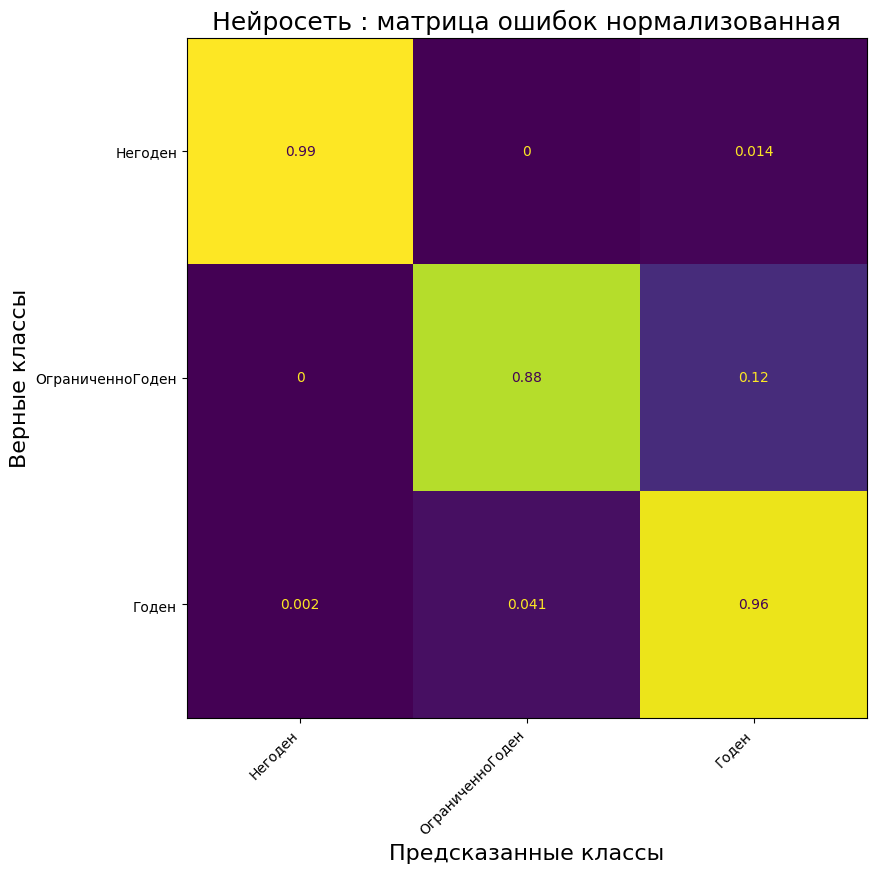

----------------------------------------------------------------------------------------------------
Нейросеть: 

Средняя точность распознавания:  94%


In [120]:
# Запуск предсказания и визуализация
eval_model(model_download, [x_train_harm, x_train_diag, x_train_gz, x_train_recom], 
                           y_train, class_labels = CLASS_DICT)

In [121]:
# Пример предсказания

# Получаем список номеров строк (индексов) с соответсвующими классами           
indexes_0 = dffix9.loc[dffix9['ЗаключениеМК'] == 'Негоден'].index.tolist()
indexes_1 = dffix9.loc[dffix9['ЗаключениеМК'] == 'ОграниченноГоден'].index.tolist()
indexes_2 = dffix9.loc[dffix9['ЗаключениеМК'] == 'Годен'].index.tolist()

# print (indexes_0)
# print (indexes_1)
# print (indexes_2)

# Случайно выбираем по одному представителю из класса
n_0 = random.choice(indexes_0)
n_1 = random.choice(indexes_1)
n_2 = random.choice(indexes_2)

# Предсказание по сформированной выборке Вредности и Диагноза
y_pred = model_download.predict([x_train_harm, x_train_diag, x_train_gz, x_train_recom])

# Перевод полученного вектора в номера классов (0,1,2)
y = np.argmax(y_pred, axis=-1)

# Сформируем таблицу с выводом реальных значений и предсказания
df_pred = pd.DataFrame({'Реальное заключение': ['Негоден', 'ОграниченноГоден', 'Годен'],
                   'Реальный вектор': [y_train[n_0], y_train[n_1], y_train[n_2]],
                   'Реальный класс': [y_data[n_0], y_data[n_1], y_data[n_2]],
                   'Предсказанный вектор': [y_pred[n_0], y_pred[n_1], y_pred[n_2]],
                   'Предсказанный класс': [y[n_0], y[n_1], y[n_2]],
                   'ГЗ': [dffix9.iloc[n_0][1], dffix9.iloc[n_1][1], dffix9.iloc[n_2][1]],
                   'Вредность': [dffix9.iloc[n_0][2], dffix9.iloc[n_1][2], dffix9.iloc[n_2][2]],
                   'Диагнозы': [dffix9.iloc[n_0][3], dffix9.iloc[n_1][3], dffix9.iloc[n_2][3]],
                   'Рекомендации': [dffix9.iloc[n_0][4], dffix9.iloc[n_1][4], dffix9.iloc[n_2][4]]
                   })

df_pred['Предсказанный вектор'] = df_pred['Предсказанный вектор'].apply(format_vector)

df_pred

54/54 [==============================] - 4s 70ms/step


,Реальное заключение,Реальный вектор,Реальный класс,Предсказанный вектор,Предсказанный класс,ГЗ,Вредность,Диагнозы,Рекомендации
0,Негоден,"[1.0, 0.0, 0.0]",0,"[0.9, 0.1, 0.0]",0,,4.2.1,Заболевания верхних дыхательных путей и кожи с...,
1,ОграниченноГоден,"[0.0, 1.0, 0.0]",1,"[0.0, 1.0, 0.0]",1,IIIа,3.1.2,"Гиперметропия,Общий медицинский осмотр,Общий м...",Допуск с ношением средств оптической коррекции...
2,Годен,"[0.0, 0.0, 1.0]",2,"[0.2, 0.3, 0.5]",2,IIIа,6.1,"Общий медицинский осмотр,Миопия,Общий медицинс...","набдюдение по месту жительства ,Поддерживать у..."


Пример загрузки данных от Заказчика, их предобработка, получения исходных данных на одного пациента, загрузка их в предобученную модель, предсказание Заключения и выдача пояснения

In [122]:
# Загружаем тестовую таблицу данных от Заказчика(здесь для примера загружается та же таблица)
df_test = pd.read_csv('/content/drive/MyDrive/internsheep1/profpat_1.csv')

<ipython-input-122-ba94c4cb9725>:2: DtypeWarning: Columns (24,25,26,43,44,45,46,47,48,54,55,56,57,58,59,60,61,62,63,64,65,77,78,79,81,84,85,86,87,88,89,90,91,92,108,109,112,113,120,121,122,123,124,125,126,127,162,163,164,168,169,170,171,172,173,174,195,196,201,202,203,204,205,206,207,208,221,222,223,228,229,230,252,253,258,259,260,261,262,263,264,265,266,267,270,271,272,273,276,277,278,279,282,283,284,285,286,287,293,294,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,363,364,365,366,367,370,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,418,419,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,470,471,472,483,484,485,486,491,492,514,515,549,550,551,552,553,554,555,564,565,578,579,580,581,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600

In [123]:
# Обрабатываем таблицу данных до необходимого формата
df_c_test = getclin(df_test)

# Вывод размера сформированной таблицы
print (df_c_test.shape)


df_c_test.ЗаключениеМК.value_counts()

(1420, 5)


Годен               1284
ОграниченноГоден     125
Негоден               11
Name: ЗаключениеМК, dtype: int64

In [124]:
# Формирование исходных данных на одного пациента из таблицы

# Номер пациента (задаем случайным образом от 0 до количества строк в обработанной таблицы-1)
# Получаем список номеров строк (индексов)          
inds = df_c_test.index.tolist()

# Случайно выбираем одного пациента
n_0 = random.choice(inds)
print ('Номер строки записи пациента: ',n_0)

# Пример текста записи
print(df_c_test.values[n_0])

# Вредность, диагнозы, рекомендации от УС
x_test_harm, x_test_diag, x_test_gz,  x_test_recom = getXdata (df_c_test)


# Значения реальных классов для контроля точности в формате класса и векторного представления класса
y_data_test, y_vect_test = Y_to_OHE(df_c_test)

y_vec_list = list(y_vect_test)
y_data_list = list(y_data_test)

x_harm_list = list(df_c_test['Вредность'])
x_diag_list = list(df_c_test['Диагнозы'])
x_recom_list = list(df_c_test['Рекомендации'])
x_gz_list = list(df_c_test['ГруппаЗдоровья'])

Номер строки записи пациента:  78
['Годен' 'IIIа' '1.50,4.3.1'
 'Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности,Общий медицинский осмотр'
 '']


In [125]:
# Предсказание по данным пациента Вредности и Диагноза
y_pred = model_download.predict([x_test_harm, x_test_diag, x_test_gz, x_test_recom])

y_pred_list = list(y_pred)

# Перевод полученного вектора в номера классов (0,1,2)
y = np.argmax(y_pred, axis=-1)

y_class_list = list(y)

# Вывод Предсказанного заключения на пациента, и причин, по которым такое заключение сформировано
# Заключение
for key, value in CLASS_DICT.items():
    if value == y[n_0]:
        print('Заключение РС:',key)

# Детали заключения:
# Группа здоровья пациента
print ('Пациент состоит на учете с диспансерной группой:', x_gz_list[n_0])

# Вредные факторы
print ('Пациент работает с вредными факторами:', x_harm_list[n_0])              

# Диагнозы
print ('У пациента поставлены диагнозы узкими специалистами:', x_diag_list[n_0]) 

# Рекомендации
print ('Пациенту даны рекомендации узкими специалистами:', x_recom_list[n_0]) 

# Фактическое заключение
for key1, value1 in CLASS_DICT.items():
    if value1 == y_data_list[n_0]:
        print('Заключение факт:',key1)

45/45 [==============================] - 3s 75ms/step
Заключение РС: Годен
Пациент состоит на учете с диспансерной группой: IIIа
Пациент работает с вредными факторами: 1.50,4.3.1
У пациента поставлены диагнозы узкими специалистами: Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности,Общий медицинский осмотр
Пациенту даны рекомендации узкими специалистами: 
Заключение факт: Годен


45/45 [==============================] - 2s 47ms/step


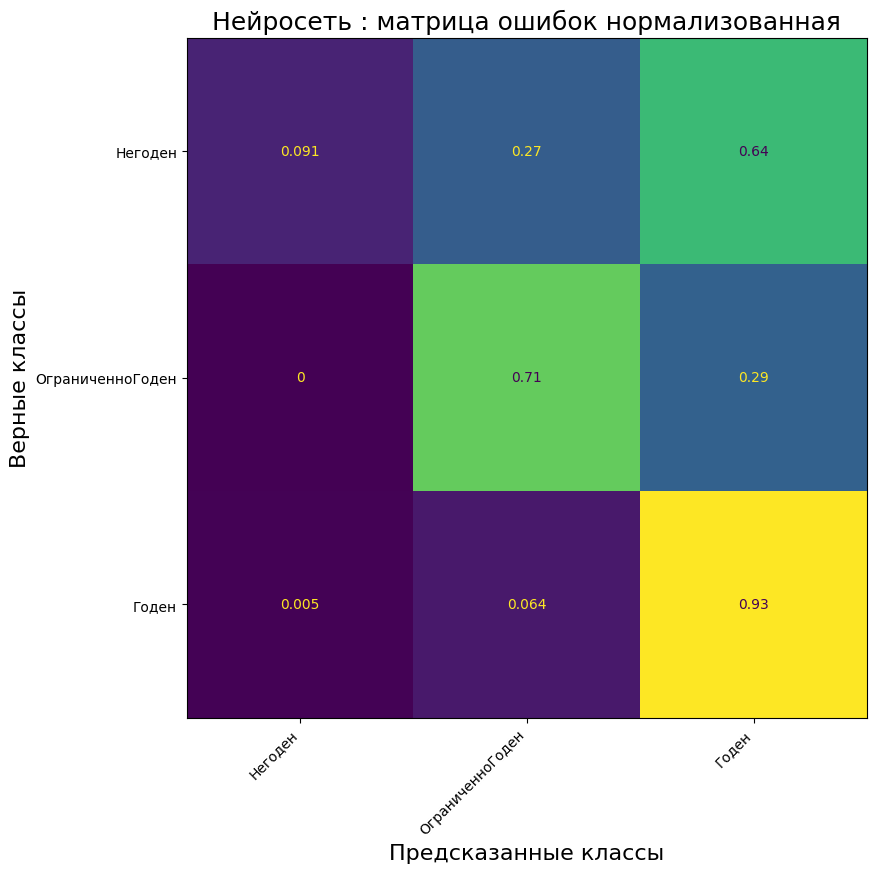

----------------------------------------------------------------------------------------------------
Нейросеть: 

Средняя точность распознавания:  58%


In [126]:
#  Запуск предсказания и визуализация на тестовой выборке
eval_model(model_download, [x_test_harm, x_test_diag, x_test_gz, x_test_recom], 
                           y_vect_test, class_labels = CLASS_DICT)

In [128]:
# Пример предсказания

# Получаем список номеров строк (индексов) с соответсвующими классами           
indexes_0 = df_c_test.loc[df_c_test['ЗаключениеМК'] == 'Негоден'].index.tolist()
indexes_1 = df_c_test.loc[df_c_test['ЗаключениеМК'] == 'ОграниченноГоден'].index.tolist()
indexes_2 = df_c_test.loc[df_c_test['ЗаключениеМК'] == 'Годен'].index.tolist()

# print (indexes_0)
# print (indexes_1)
# print (indexes_2)

# Случайно выбираем по одному представителю из класса
n_0 = random.choice(indexes_0)
n_1 = random.choice(indexes_1)
n_2 = random.choice(indexes_2)

# Предсказание по сформированной выборке Вредности и Диагноза
y_pred = model_download.predict([getXdata (df_c_test)])

# Перевод полученного вектора в номера классов (0,1,2)
y = np.argmax(y_pred, axis=-1)

# Сформируем таблицу с выводом реальных значений и предсказания
df_pred = pd.DataFrame({'Реальное заключение': ['Негоден', 'ОграниченноГоден', 'Годен'],
                  #  'Реальный вектор': [y_vec_list[n_0], y_vec_list[n_1], y_vec_list[n_2]],
                   'Реальный класс': [y_data_list[n_0], y_data_list[n_1], y_data_list[n_2]],
                   'Предсказанный вектор': [y_pred[n_0], y_pred[n_1], y_pred[n_2]],
                   'Предсказанный класс': [y[n_0], y[n_1], y[n_2]],
                   'ГЗ': [df_c_test.iloc[n_0][1], df_c_test.iloc[n_1][1], df_c_test.iloc[n_2][1]],
                   'Вредность': [df_c_test.iloc[n_0][2], df_c_test.iloc[n_1][2], df_c_test.iloc[n_2][2]],
                   'Диагнозы': [df_c_test.iloc[n_0][3], df_c_test.iloc[n_1][3], df_c_test.iloc[n_2][3]],
                   'Рекомендации': [df_c_test.iloc[n_0][4], df_c_test.iloc[n_1][4], df_c_test.iloc[n_2][4]]
                   })

df_pred['Предсказанный вектор'] = df_pred['Предсказанный вектор'].apply(format_vector)

df_pred

45/45 [==============================] - 4s 91ms/step


,Реальное заключение,Реальный класс,Предсказанный вектор,Предсказанный класс,ГЗ,Вредность,Диагнозы,Рекомендации
0,Негоден,0,"[0.2, 0.1, 0.7]",2,,"18.2,18.1,1.1,1.39,1.50,4.3.2,5.1,11.1,11.3,11.4","Общий медицинский осмотр,Последствия травмы гл...",
1,ОграниченноГоден,1,"[0.0, 1.0, 0.0]",1,II,"1.30.1,3.1.8.1","Общий медицинский осмотр,Миопия,Общий медицинс...",Использование средств оптической коррекции зрения
2,Годен,2,"[0.2, 0.1, 0.7]",2,I,4.2.5,"Общий медицинский осмотр,Общий медицинский осм...",


In [101]:
# Сформируем таблицу с выводом реальных значений и предсказания
df_pred1 = pd.DataFrame({
                   'РеалКласс': y_data_list,
                   'ПредВектор': y_pred_list,
                   'ПредКласс': y_class_list,
                   'ГруппаЗдоровья': x_gz_list,
                   'Вредный фактор': x_harm_list,
                   'Диагнозы': x_diag_list,
                   'Рекомендации': x_recom_list
                   })
# Обработка вывода вектора
df_pred1['ПредВектор'] = df_pred1['ПредВектор'].apply(format_vector)

df_pred1

,РеалКласс,ПредВектор,ПредКласс,ГруппаЗдоровья,Вредный фактор,Диагнозы,Рекомендации
0,2,"[0.1, 0.1, 0.7]",2,I,11.4,"Общий медицинский осмотр,Общий медицинский осм...",без патологий
1,2,"[0.1, 0.1, 0.8]",2,IIIа,4.2.5,"Общий медицинский осмотр,Общий медицинский осм...",без патологий
2,1,"[0.2, 0.3, 0.4]",2,II,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс...",Допуск с ношением средств оптической коррекции...
3,2,"[0.2, 0.1, 0.7]",2,I,11.1,"Общий медицинский осмотр,Общий медицинский осм...",
4,1,"[0.2, 0.6, 0.2]",1,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Использование средств оптической коррекции зрения
...,...,...,...,...,...,...,...
1415,2,"[0.1, 0.1, 0.8]",2,I,"4.4,4.5,6.1","Общий медицинский осмотр,Общий медицинский осм...",
1416,2,"[0.1, 0.1, 0.8]",2,I,4.4,"Общий медицинский осмотр,Общий медицинский осм...",
1417,2,"[0.1, 0.1, 0.8]",2,I,3.1.8.2,"Общий медицинский осмотр,Общий медицинский осм...",
1418,2,"[0.2, 0.1, 0.8]",2,I,"4.2.5,6.1","Общий медицинский осмотр,Общий медицинский осм...",
